In [4]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk.collocations as collocations
from nltk.collocations import *
import re
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import pickle
import nltk
from nltk.corpus import stopwords
import random
import itertools
import pandas as pd

In [2]:
f = open('./movie_reviews/train.tsv', 'r')
# loop over lines in the file and use the first limit of them
phrasedata = []
for line in f:
  # ignore the first line starting with Phrase and read all lines
  if (not line.startswith('Phrase')):
    # remove final end of line character
    line = line.strip()
    # each line has 4 items separated by tabs
    # ignore the phrase and sentence ids, and keep the phrase and sentiment
    phrasedata.append(line.split('\t')[2:4])
f.close()

In [3]:
random.shuffle(phrasedata)
phraselist = phrasedata
for phrase in phraselist[:10]:
    print(phrase)

['so darned assured', '2']
['Analyze That ,', '2']
["is not that it 's all derivative , because plenty of funny movies recycle old tropes .", '1']
['with enough unexpected twists', '3']
['worse stunt editing or', '1']
['cinematic icons', '2']
["The premise of `` Abandon '' holds promise , ... but its delivery is a complete mess .", '1']
['spark or two', '2']
['to stand-up', '2']
['of an Alice', '2']


In [8]:
sentiment_map = {
    0: "negative",
    1: "somewhat negative",
    2: "neutral",
    3: "somewhat positive",
    4: "positive"
}

In [22]:
text_df = pd.DataFrame(phraselist, columns=["Phrase", "Sentiment"])
text_df["Sentiment"] = text_df["Sentiment"].astype("int")
text_df["Sentiment"] = text_df["Sentiment"].map(sentiment_map)
text_df.head()

,Phrase,Sentiment
0,so darned assured,neutral
1,"Analyze That ,",neutral
2,"is not that it 's all derivative , because ple...",somewhat negative
3,with enough unexpected twists,somewhat positive
4,worse stunt editing or,somewhat negative


In [26]:
distro_group = text_df.groupby("Sentiment").size().reset_index()
distro_group.columns = ["Sentiment", "count"]
#distro_group["Sentiment"] = distro_group["Sentiment"].map(sentiment_map)

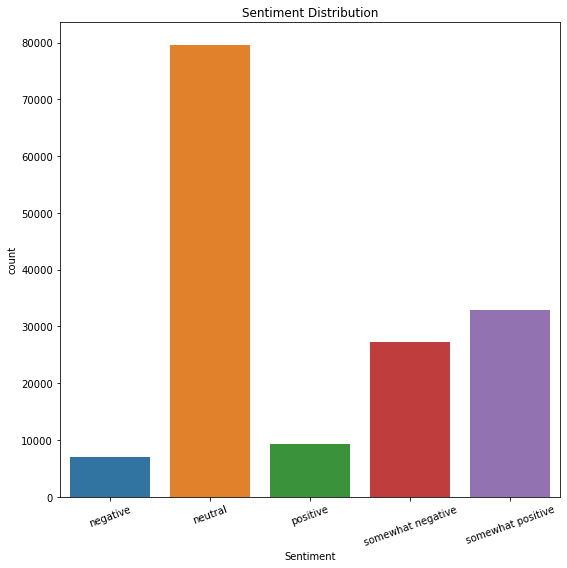

In [32]:
plt.figure(figsize=(8,8))
ax = sns.barplot(x="Sentiment", y="count", data=distro_group)
ax.set_xticklabels(ax.get_xticklabels(), rotation=20)
ax.set_title(label="Sentiment Distribution")
plt.savefig("./sentiment_distribution.png")
plt.tight_layout()
plt.show()

In [7]:
distro_group

,Sentiment,count
0,0,7072
1,1,27273
2,2,79582
3,3,32927
4,4,9206


In [4]:
tokenizer = nltk.RegexpTokenizer(r"\w+")
phrasedocs = []
for phrase in phraselist:
    tokens = tokenizer.tokenize(phrase[0])
    phrasedocs.append((tokens, int(phrase[1])))

In [23]:
phrasedocs[:25]

[(['frank', 'humanity'], 2),
 (['most', 'slyly', 'exquisite', 'anti', 'adult', 'movies'], 3),
 (['tight', 'and', 'truthful'], 3),
 (['to', 'their', 'characters'], 2),
 (['Same',
   'song',
   'second',
   'verse',
   'coulda',
   'been',
   'better',
   'but',
   'it',
   'coulda',
   'been',
   'worse'],
  2),
 (['under',
   'the',
   'right',
   'conditions',
   'it',
   's',
   'goofy',
   'LRB',
   'if',
   'not',
   'entirely',
   'wholesome',
   'RRB',
   'fun'],
  3),
 (['reopens',
   'an',
   'interesting',
   'controversy',
   'and',
   'never',
   'succumbs',
   'to',
   'sensationalism'],
  3),
 (['sell', 'many', 'records'], 3),
 (['Gives', 'an', 'intriguing', 'twist'], 3),
 (['for', 'artistic', 'integrity'], 2),
 (['of', 'our', 'time'], 2),
 (['demonstrated',
   'a',
   'knack',
   'for',
   'mixing',
   'action',
   'and',
   'idiosyncratic',
   'humor',
   'in',
   'his',
   'charming',
   '2000',
   'debut',
   'Shanghai',
   'Noon'],
  3),
 (['a', 'cinematic', 'year'], 

In [5]:
stop_words = set(stopwords.words('english'))
no_stop_phrases = []
for phrase, label in phrasedocs:
    phrase = [word for word in phrase if word not in stop_words]
    no_stop_phrases.append((phrase, label))

In [26]:
no_stop_phrases[:25]

[(['frank', 'humanity'], 2),
 (['slyly', 'exquisite', 'anti', 'adult', 'movies'], 3),
 (['tight', 'truthful'], 3),
 (['characters'], 2),
 (['Same', 'song', 'second', 'verse', 'coulda', 'better', 'coulda', 'worse'],
  2),
 (['right',
   'conditions',
   'goofy',
   'LRB',
   'entirely',
   'wholesome',
   'RRB',
   'fun'],
  3),
 (['reopens',
   'interesting',
   'controversy',
   'never',
   'succumbs',
   'sensationalism'],
  3),
 (['sell', 'many', 'records'], 3),
 (['Gives', 'intriguing', 'twist'], 3),
 (['artistic', 'integrity'], 2),
 (['time'], 2),
 (['demonstrated',
   'knack',
   'mixing',
   'action',
   'idiosyncratic',
   'humor',
   'charming',
   '2000',
   'debut',
   'Shanghai',
   'Noon'],
  3),
 (['cinematic', 'year'], 2),
 (['Works', 'pretty', 'contagious', 'fun'], 3),
 (['level', 'insight', 'made', 'LRB', 'Eyre', 'RRB'], 2),
 (['Jackass',
   'vulgar',
   'cheap',
   'looking',
   'version',
   'Candid',
   'Camera',
   'staged',
   'Marquis',
   'de',
   'Sade',
   'se

In [6]:
docs = []
for phrase in no_stop_phrases:
    lowerphrase = ([w.lower() for w in phrase[0]], phrase[1])
    docs.append(lowerphrase)
for phrase in docs[:10]:
    print(phrase)

(['erotic'], 1)
(['illogic', 'characters'], 1)
(['favour', 'approach'], 2)
(['quirky', 'characters', 'odd', 'situations', 'kilter', 'dialogue'], 2)
(['manners'], 2)
(['alfonso'], 2)
(['contemptible', 'imitator', 'starring', 'snl', 'acting', 'like', '8', 'year', 'old', 'channeling', 'roberto', 'benigni'], 0)
(['dismissed', 'heroes', 'would', 'film', 'n', 'painfully', 'forced', 'false', 'fabricated'], 0)
(['distracted', 'movie', 'quick', 'movements'], 2)
(['pointless', 'meandering', 'celebration'], 1)


In [7]:
all_words_list = [word for (sent, cat) in docs for word in sent]
all_words = nltk.FreqDist(all_words_list)
print(len(all_words))

15253


In [8]:
word_items = all_words.most_common(1000)
word_features = [word for (word, count) in word_items]

In [31]:
word_items[:10]

[('film', 6733),
 ('movie', 6241),
 ('the', 4668),
 ('n', 4025),
 ('one', 3784),
 ('like', 3190),
 ('a', 2780),
 ('story', 2539),
 ('rrb', 2438),
 ('good', 2261)]

In [30]:
word_features[:10]

['film', 'movie', 'the', 'n', 'one', 'like', 'a', 'story', 'rrb', 'good']

## Unigrams

In [32]:
def document_features(document, word_features):
    document_words = set(document)
    #we open a Pytnon dictionary instead of a list
    features = {}
    for word in word_features:
        #checking if the word from word_features matches a word in the document
        features['contains({})'.format(word)] = (word in document_words)
    return features

In [42]:
doc_chunks = np.array_split(np.array(docs), 100)

C:\Users\Alec\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [43]:
%%time
feature_set_chunks = []
for chunk in doc_chunks:
    feature_set_chunks.append(
        [(document_features(chunk_sent[0], word_features), chunk_sent[1]) 
         for chunk_sent in chunk]
    )

Wall time: 1min 21s


In [44]:
featuresets = list(itertools.chain.from_iterable(feature_set_chunks))

In [49]:
try:
    del doc_chunks
except Exception as e:
    print(e)
    
try:
    del feature_set_chunks
except Exception as e:
    print(e)
    
try:
    del all_words_list
except Exception as e:
    print(e)

try:
    del all_words_list

except Exception as e:
    print(e)

try:
    del phrasedata
except Exception as e:
    print(e)
    
try:
    del phrasedocs
except Exception as e:
    print(e)

name 'all_words_list' is not defined
name 'phrasedata' is not defined
name 'phrasedocs' is not defined


In [51]:
try:
    del no_stop_phrases
except Exception as e:
    print(e)

In [17]:
import sys
var_mems = []
local_vars = list(locals().items())
for var, obj in local_vars:
    if not var.startswith("_"):
        print(var, np.round(sys.getsizeof(obj) / 1e6, 4))
#         var_mems.append(var, np.round(sys.getsizeof(obj) / 1e6, 4))

In 0.0003
Out 0.0002
get_ipython 0.0001
exit 0.0001
quit 0.0001
pd 0.0001
nltk 0.0001
plt 0.0001
sns 0.0001
np 0.0001
collocations 0.0001
BigramCollocationFinder 0.0011
TrigramCollocationFinder 0.0011
QuadgramCollocationFinder 0.0011
re 0.0001
KFold 0.0011
precision_score 0.0001
recall_score 0.0001
f1_score 0.0001
confusion_matrix 0.0001
pickle 0.0001
stopwords 0.0017
random 0.0001
itertools 0.0001
f 0.0002
line 0.0001
phraselist 1.3208
phrase 0.0001
tokenizer 0.0001
tokens 0.0001
stop_words 0.0084
no_stop_phrases 1.3208
label 0.0
docs 1.3208
lowerphrase 0.0001
all_words 0.5899
word_items 0.009
word_features 0.009
alpha 0.0001
bigram_measures 0.0001
finder 0.0001
scored 0.1185
bigram_features 0.0043
bi_document_features 0.0001
chunk 0.0001
featuresets2 1.2529
sys 0.0001
var_mems 0.0001


In [20]:
import time
def kfold_naive_bayes(feature_sets, splits=5):
    kf = KFold(n_splits=splits)
    scores = []
    start_time = time.time()
    for i, (train, test) in enumerate(kf.split(feature_sets)):
        print(f"split {i+1} being trained")
        classifier = nltk.NaiveBayesClassifier.train(
            np.array(feature_sets)[train]
        )
        scores.append(
            nltk.classify.accuracy(classifier, 
                                   np.array(feature_sets)[test])
        )
    
        print(f"Split {i+1} training time: {(time.time() - start_time) / 60:5.2f}mins")
    return classifier, scores

In [26]:
def score_model(true_labels, predictions):
    precision = precision_score(true_labels, predictions, average='macro').round(4)
    recall = recall_score(true_labels, predictions, average='macro').round(4)
    f_measure = f1_score(true_labels, predictions, average='macro').round(4)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F Measure: ", f_measure)
    return precision, recall, f_measure

In [57]:
%%time
uni_15fold_1000words_results = kfold_naive_bayes(featuresets, splits=15)

split 0 being trained
split 0 being trained
split 0 being trained
split 0 being trained
split 0 being trained
split 0 being trained
split 0 being trained
split 0 being trained
split 0 being trained
split 0 being trained
split 0 being trained
split 0 being trained
split 0 being trained
split 0 being trained
split 0 being trained
Split 0 training time: 87.74mins
Wall time: 1h 27min 44s


In [58]:
with open("./models/uni_1000word_model_15fold.pickle", 'wb') as f:
    pickle.dump(uni_15fold_1000words_results[0], f)

In [65]:
print(f"Fold Accuracies:\n {uni_15fold_1000words_results[1]} \n")
print(f"Mean Accuracy: {np.mean(uni_15fold_1000words_results[1]).round(3)}")

Fold Accuracies:
 [0.5725682429834679, 0.5705497885428681, 0.565359477124183, 0.5685313341022683, 0.5676662821991542, 0.5695886197616301, 0.5689158016147635, 0.5789119569396386, 0.5799692425990004, 0.5717031910803537, 0.5705497885428681, 0.5665128796616686, 0.5779507881584006, 0.5771818531334102, 0.5681468665897732] 

Mean Accuracy: 0.572


In [60]:
%%time
uni_15fold_preds_labs = [(uni_15fold_1000words_results[0].classify(features), label) for features, label in featuresets] 

Wall time: 22min 8s


In [61]:
preds = []
trues = []
for pred, true in uni_15fold_preds_labs:
    preds.append(pred)
    trues.append(true)

trues_preds_15fold = [trues, preds]
uni_15fold_scores = score_model(trues_preds_15fold[0], trues_preds_15fold[1])

Precision:  0.488
Recall:  0.3806
F Measure:  0.4084


In [ ]:
# pd.DataFrame(zip(trues_preds_15fold), columns=

In [64]:
confusion_matrix(trues_preds_15fold[0], trues_preds_15fold[1])

array([[ 1544,  1899,  3094,   446,    89],
       [ 1219,  6898, 16703,  2132,   321],
       [  643,  4405, 69273,  4753,   508],
       [  322,  1932, 18703, 10377,  1593],
       [   81,   403,  3030,  3425,  2267]], dtype=int64)

### Bigrams

In [9]:
stopwords = nltk.corpus.stopwords.words('english')

def alpha(w):
    pattern = re.compile('^[^a-z]+$')
    if(pattern.match(w)):
        return True
    else:
        return False

#creating bigrams features for the corpus and applying cleaning steps
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(all_words)
finder.apply_word_filter(alpha)
finder.apply_word_filter(lambda w: w in stopwords)
scored = finder.score_ngrams(bigram_measures.raw_freq)
scored[:10]

[(('10th', 'angry'), 6.556087327083197e-05),
 (('12th', 'choosing'), 6.556087327083197e-05),
 (('13th', 'incarnation'), 6.556087327083197e-05),
 (('15th', 'ease'), 6.556087327083197e-05),
 (('1930s', 'nightmares'), 6.556087327083197e-05),
 (('1940s', 'aspirations'), 6.556087327083197e-05),
 (('1950s', 'ww'), 6.556087327083197e-05),
 (('1960s', 'spaces'), 6.556087327083197e-05),
 (('1970s', 'macaroni'), 6.556087327083197e-05),
 (('1980s', 'ascension'), 6.556087327083197e-05)]

In [10]:
#extracting clean bigrams (no frequency information)
bigram_features = [bigram for (bigram, count) in scored[:500]]
#printing the first 30 for confirmation
bigram_features[:30]

[('10th', 'angry'),
 ('12th', 'choosing'),
 ('13th', 'incarnation'),
 ('15th', 'ease'),
 ('1930s', 'nightmares'),
 ('1940s', 'aspirations'),
 ('1950s', 'ww'),
 ('1960s', 'spaces'),
 ('1970s', 'macaroni'),
 ('1980s', 'ascension'),
 ('19th', 'century'),
 ('20th', 'footnotes'),
 ('21st', 'latino'),
 ('30s', '40s'),
 ('3d', 'ungainly'),
 ('40s', 'ultra'),
 ('4ever', 'indecent'),
 ('4th', 'fun'),
 ('4w', 'resolutions'),
 ('50s', 'wyman'),
 ('51st', 'fulford'),
 ('5ths', 'xerox'),
 ('60s', 'sword'),
 ('65th', 'reunion'),
 ('70s', 'perhaps'),
 ('7th', 'oral'),
 ('80s', 'dreamscape'),
 ('8th', 'drastic'),
 ('90s', 'typifies'),
 ('aaa', 'lip')]

In [11]:
def bi_document_features(document, bigram_features):
    document_words = list(nltk.bigrams(document))
    features = {}
    for word in bigram_features:
        #boolean logic will retunt 'True' if there is a match, or 'False' if not
        features['contains({})'.format(word)] = (word in document_words)
    return features

In [12]:
doc_chunks = np.array_split(np.array(docs), 100)

C:\Users\Alec\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [13]:
%%time
feature_set_chunks = []
for chunk in doc_chunks:
    feature_set_chunks.append(
        [(bi_document_features(chunk_sent[0], bigram_features), chunk_sent[1]) 
         for chunk_sent in chunk]
    )

Wall time: 1min 26s


In [14]:
featuresets2 = list(itertools.chain.from_iterable(feature_set_chunks))

In [15]:
try:
    del doc_chunks
except Exception as e:
    print(e)
    
try:
    del feature_set_chunks
except Exception as e:
    print(e)
    
try:
    del all_words_list
except Exception as e:
    print(e)

try:
    del all_words_list

except Exception as e:
    print(e)

try:
    del phrasedata
except Exception as e:
    print(e)
    
try:
    del phrasedocs
except Exception as e:
    print(e)
    
try:
    del 
except Exception as e:
    print(e)

try:
    del 
except Exception as e:
    print(e)


name 'all_words_list' is not defined


In [19]:
import gc
gc.collect()

67

In [21]:
%%time
bi_5fold_results = kfold_naive_bayes(featuresets2, splits=5)

split 1 being trained
Split 1 training time:  3.62mins
split 2 being trained
Split 2 training time:  7.15mins
split 3 being trained
Split 3 training time: 10.93mins
split 4 being trained
Split 4 training time: 13.91mins
split 5 being trained
Split 5 training time: 16.72mins
Wall time: 16min 42s


In [22]:
with open("./models/bi_5fold_results_model.pickle", 'wb') as f:
    pickle.dump(bi_5fold_results[0], f)

In [23]:
print(f"Fold Accuracies:\n {bi_5fold_results[1]} \n")
print(f"Mean Accuracy: {np.mean(bi_5fold_results[1]).round(3)}")

Fold Accuracies:
 [0.5069204152249135, 0.5142573369216967, 0.5124311162373446, 0.5073369216967832, 0.5116942201717288] 

Mean Accuracy: 0.511


In [24]:
%%time
bi_5fold_preds_labs = [(bi_5fold_results[0].classify(features), label) for features, label in featuresets2] 

Wall time: 8min 13s


In [27]:
preds = []
trues = []
for pred, true in bi_5fold_preds_labs:
    preds.append(pred)
    trues.append(true)

trues_preds_5fold_bi = [trues, preds]
bi_5fold_scores = score_model(trues_preds_5fold_bi[0], trues_preds_5fold_bi[1])

Precision:  0.6066
Recall:  0.2027
F Measure:  0.1409


## Part-Of-Speech Tagging

In [28]:
# this function takes a document list of words and returns a feature dictionary
# it runs the default pos tagger (the Stanford tagger) on the document
#   and counts 4 types of pos tags to use as features
def POS_features(document, word_features):
    document_words = set(document)
    tagged_words = nltk.pos_tag(document)
    features = {}
    for word in word_features:
        features['contains({})'.format(word)] = (word in document_words)
    numNoun = 0
    numVerb = 0
    numAdj = 0
    numAdverb = 0
    for (word, tag) in tagged_words:
        if tag.startswith('N'): numNoun += 1
        if tag.startswith('V'): numVerb += 1
        if tag.startswith('J'): numAdj += 1
        if tag.startswith('R'): numAdverb += 1
    features['nouns'] = numNoun
    features['verbs'] = numVerb
    features['adjectives'] = numAdj
    features['adverbs'] = numAdverb
    return features

In [29]:
doc_chunks = np.array_split(np.array(docs), 100)

C:\Users\Alec\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [30]:
%%time
feature_set_chunks = []
for chunk in doc_chunks:
    feature_set_chunks.append(
        [(POS_features(chunk_sent[0], word_features), chunk_sent[1]) 
         for chunk_sent in chunk]
    )

Wall time: 3min 31s


In [31]:
POS_featuresets = list(itertools.chain.from_iterable(feature_set_chunks))
print(len(POS_featuresets[0][0].keys()))

1004


In [32]:
try:
    del doc_chunks
except Exception as e:
    print(e)
    
try:
    del feature_set_chunks
except Exception as e:
    print(e)
    
try:
    del all_words_list
except Exception as e:
    print(e)

try:
    del all_words_list

except Exception as e:
    print(e)

try:
    del phrasedata
except Exception as e:
    print(e)
    
try:
    del phrasedocs
except Exception as e:
    print(e)
    
try:
    del phraselist
except Exception as e:
    print(e)

try:
    del featuresets2
except Exception as e:
    print(e)

try:
    del no_stop_phrases
except Exception as e:
    print(e)
    
gc.collect()

name 'all_words_list' is not defined
name 'all_words_list' is not defined
name 'phrasedata' is not defined
name 'phrasedocs' is not defined


8

In [33]:
%%time
pos_5fold_results = kfold_naive_bayes(POS_featuresets, splits=5)

split 1 being trained
Split 1 training time:  6.84mins
split 2 being trained
Split 2 training time: 13.14mins
split 3 being trained
Split 3 training time: 19.65mins
split 4 being trained
Split 4 training time: 26.39mins
split 5 being trained
Split 5 training time: 33.62mins
Wall time: 33min 37s


In [34]:
with open("./models/pos_5fold_results_model.pickle", 'wb') as f:
    pickle.dump(pos_5fold_results[0], f)

In [35]:
print(f"Fold Accuracies:\n {pos_5fold_results[1]} \n")
print(f"Mean Accuracy: {np.mean(pos_5fold_results[1]).round(3)}")

Fold Accuracies:
 [0.5564206074586697, 0.5543380750993208, 0.5580545943867743, 0.5543380750993208, 0.5544021530180699] 

Mean Accuracy: 0.556


In [36]:
%%time
pos_5fold_preds_labs = [(pos_5fold_results[0].classify(features), label) for features, label in POS_featuresets] 

Wall time: 18min 52s


In [37]:
preds = []
trues = []
for pred, true in pos_5fold_preds_labs:
    preds.append(pred)
    trues.append(true)

trues_preds_5fold_pos = [trues, preds]
pos_5fold_scores = score_model(trues_preds_5fold_pos[0], trues_preds_5fold_pos[1])

Precision:  0.4382
Recall:  0.3948
F Measure:  0.4062
